<a href="https://colab.research.google.com/github/matt14e/StitchAI/blob/main/Stitchmodel3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip -q install lightning torchvision pyembroidery pillow

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Edit here if folders are moved
DATA_ROOT = "/content/drive/MyDrive/Embroidery Files"
IMG_DIR   = f"{DATA_ROOT}/PNG_image_files"   # PNGs
DST_DIR   = f"{DATA_ROOT}/DST_digitized_files"   # DSTs

In [20]:
#sanity check the folders
import pathlib, textwrap

print("📷  sample PNG files:")
for p in list(pathlib.Path(IMG_DIR).glob("*.[pP][nN][gG]"))[:5]:
    print("   ", p.name)

print("\n🧵  sample DST files:")
for p in list(pathlib.Path(DST_DIR).glob("*.[dD][sS][tT]"))[:5]:
    print("   ", p.name)


📷  sample PNG files:
    Cod_Fish_Logo.PNG
    MLPP_LOGO.PNG
    LF_LOGO.PNG
    Andrews_Logo.PNG
    Royal_Logo.PNG

🧵  sample DST files:
    Elite.DST
    adam.DST
    Lehigh.DST
    Moon-Walkaz-Text.DST
    Kamp.DST


In [21]:
%%writefile dataset.py
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
from pyembroidery import read

SCALE = 4096.0

# --- file patterns -----------------------------------------------------------
IMG_EXTS = ("*.png", "*.PNG", "*.jpg", "*.JPG")
DST_EXTS = ("*.dst", "*.DST")

class EmbroDataset(Dataset):
    """
    Yields (image_tensor, stitch_tensor) pairs.

    image_tensor  : C × H × W   float32 in [0, 1]
    stitch_tensor : L × 3       (Δx, Δy, flag)  float32
    """
    def __init__(self, img_dir, dst_dir, transform=None, max_len=20000):
        img_dir, dst_dir = Path(img_dir), Path(dst_dir)

        # -------- gather every image and dst file into dicts ---------------
        img_files = {}
        for pat in IMG_EXTS:
            for p in img_dir.glob(pat):
                img_files[p.stem] = p

        dst_files = {}
        for pat in DST_EXTS:
            for d in dst_dir.glob(pat):
                dst_files[d.stem] = d

        # -------- keep only names that exist in *both* dicts --------------
        self.common_names = sorted(img_files.keys() & dst_files.keys())
        if not self.common_names:
            raise RuntimeError("No matching (image, DST) pairs found!")

        self.img_files  = img_files
        self.dst_files  = dst_files
        self.transform  = transform
        self.max_len    = max_len

    # ------------------------------------------------------------------------
    def __len__(self):
        return len(self.common_names)

    def __getitem__(self, idx):
        name = self.common_names[idx]

        # load (optionally) transform image
        img_path = self.img_files[name]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # load DST stitches
        dst_path  = self.dst_files[name]

        #new
        pattern = read(str(dst_path))
        raw = torch.tensor(pattern.stitches, dtype=torch.float32)[: self.max_len]
        raw[:, :2] /= SCALE
        stitches = raw
        return img, stitches


Overwriting dataset.py


In [22]:
%%writefile model.py
import torch, torch.nn as nn

class EmbroNet(nn.Module):
    """Tiny CNN encoder + GRU decoder baseline."""
    def __init__(self, hidden=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64,128, 3, 2, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)          # 128×1×1
        )
        self.enc_fc  = nn.Linear(128, hidden)

        self.gru     = nn.GRU(3, hidden, num_layers=2, batch_first=True)
        self.dec_fc  = nn.Linear(hidden, 3)

    def forward(self, img, prev_cmds):
        B = img.size(0)
        h0 = self.encoder(img).view(B, -1)      # B×128
        h0 = torch.tanh(self.enc_fc(h0)).unsqueeze(0).repeat(2, 1, 1)
        out, _ = self.gru(prev_cmds, h0)        # B×L×H
        return self.dec_fc(out)                 # B×L×3


Overwriting model.py


In [7]:
import torch
import lightning as L
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from lightning.pytorch.callbacks import ModelCheckpoint          # ➊ NEW
from lightning.pytorch.loggers   import CSVLogger                # ➊ NEW
from dataset import EmbroDataset
from model   import EmbroNet

# ---------- 1. custom collate_fn ---------------------------------
def pad_collate(batch):
    """
    batch = list of (img_tensor, seq_tensor) pairs
    Returns:
        imgs   : B×3×128×128
        tgt    : B×Lmax×3  (padded with 0s)
        lens   : list[int] (original sequence lengths)
    """
    imgs, seqs = zip(*batch)
    imgs = torch.stack(imgs)                   # all same size

    lens    = [s.size(0) for s in seqs]
    Lmax    = max(lens)
    padded  = torch.zeros(len(seqs), Lmax, 3)  # default zeros = padding
    for i, s in enumerate(seqs):
        padded[i, : lens[i], :] = s
    return imgs, padded, torch.tensor(lens)

# ---------- 2. LightningModule -----------------------------------
class LitModule(L.LightningModule):
    def __init__(self, ss_start=1.0, ss_end=0.0, ss_epochs=40):
        super().__init__()
        self.net = EmbroNet()
        self.loss_fn = torch.nn.MSELoss(reduction="mean")
        self.ss_start = ss_start
        self.ss_end = ss_end
        self.ss_epochs = ss_epochs

    def current_ss_ratio(self):
        # Linearly decay teacher-forcing ratio over ss_epochs
        epoch = self.current_epoch
        ratio = self.ss_start - (self.ss_start - self.ss_end) * min(epoch, self.ss_epochs) / self.ss_epochs
        return ratio

    def forward(self, img, prev_cmds):
        return self.net(img, prev_cmds)

    def training_step(self, batch, _):
        img, tgt, lens = batch  # tgt: B×Lmax×3
        B, Lmax, _ = tgt.shape
        ss_ratio = self.current_ss_ratio()

        # Start with BOS (first stitch)
        preds = []
        prev = tgt[:, :1]  # B×1×3

        for t in range(1, Lmax):
            out = self(img, prev)  # B×t×3 → predict next
            pred_next = out[:, -1:]  # B×1×3
            preds.append(pred_next)

            # scheduled sampling: feed either prediction or ground truth
            use_teacher = (torch.rand(B, 1, 1, device=self.device) < ss_ratio)
            next_input = torch.where(use_teacher, tgt[:, t:t+1], pred_next.detach())
            #prev = torch.cat([prev, next_input], dim=1)  # grow the sequence
            prev = torch.cat([prev, next_input.detach()], dim=1)


        # build full prediction tensor
        pred_seq = torch.cat(preds, dim=1)  # B×(Lmax−1)×3

        # Mask-aware loss
        loss = 0.0
        for i, L in enumerate(lens):
            L = L.item()
            loss += self.loss_fn(pred_seq[i, :L-1], tgt[i, 1:L])
        loss = loss / len(lens)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("ss_ratio", ss_ratio, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), 1e-3)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "train_loss"}}

#Stand Alone Function to add white borders to image as to not have to squish or stretch images
def get_padding(img, target_size):
    w, h = img.size
    pad_w = target_size - w if w < target_size else 0
    pad_h = target_size - h if h < target_size else 0
    left   = pad_w // 2
    right  = pad_w - left
    top    = pad_h // 2
    bottom = pad_h - top
    return (left, top, right, bottom)




# ---------- 3. dataset & dataloader ------------------------------
####OLD====tfms = Compose([Resize((128,128)), ToTensor()])
####NEW####

tfms = Compose([
    Resize(256),  # Resize shortest side to 256
    Pad(padding=lambda img: get_padding(img, 256), fill=255),  # White padding
    ToTensor()
])
ds   = EmbroDataset(IMG_DIR, DST_DIR, tfms)
print("Dataset length:", len(ds))          # should be > 0

dl   = DataLoader(ds,
                  batch_size=2,
                  shuffle=True,
                  num_workers=0,            # change later if you like
                  collate_fn=pad_collate)   # ← custom collate!

# ---------- 4. train ---------------------------------------------
CKPT_DIR = "/content/drive/MyDrive/Embroidery Files/checkpoints"   # ➋ choose your folder
LOG_DIR  = "/content/drive/MyDrive/Embroidery Files/logs"          # ➋ choose your folder

ckpt_cb = ModelCheckpoint(
    dirpath   = CKPT_DIR,
    filename  = "epoch{epoch:02d}-loss{train_loss:.3f}",
    save_last = True,           # keeps 'last.ckpt' every epoch
    save_top_k= 3,              # best 3 by train_loss
    monitor   = "train_loss",
    mode      = "min",
)

csv_logger = CSVLogger(save_dir=LOG_DIR, name="run1")

#trainer = L.Trainer(fast_dev_run=True)
trainer = L.Trainer(
    max_epochs        = 30,     # or however many you want
    accelerator       = "gpu",  # switch Colab to GPU runtime!
    precision         = "16-mixed",
    callbacks         = [ckpt_cb],
    logger            = csv_logger,
    log_every_n_steps = 10,
)
####Verify####
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# View one sample from the dataset
img_tensor, _ = ds[0]
img = ToPILImage()(img_tensor)

plt.imshow(img)
plt.title("Sample Transformed Image (From Training Data)")
plt.axis("off")
plt.show()

trainer.fit(LitModule(), dl)


KeyboardInterrupt: 

Using: /content/drive/MyDrive/Embroidery Files/logs/run1/version_11/metrics.csv


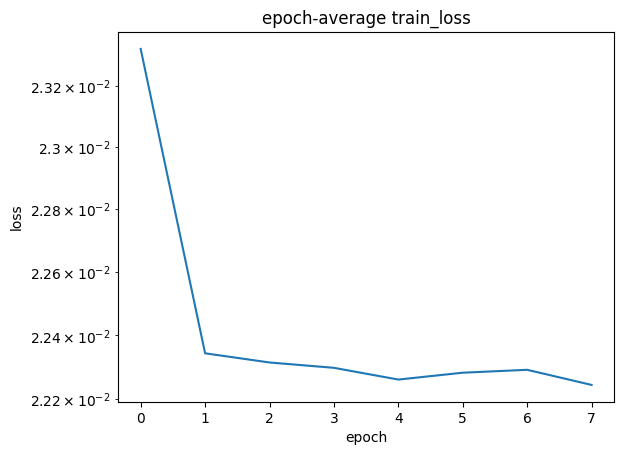

In [13]:
import glob, os, pandas as pd, matplotlib.pyplot as plt

# 🔎 1.  find the most recent metrics.csv anywhere in Drive or /content
candidates = glob.glob("/content/**/metrics.csv", recursive=True) + \
             glob.glob("/content/drive/**/metrics.csv", recursive=True)

if not candidates:
    raise FileNotFoundError("No metrics.csv files found—did your run finish an epoch and use CSVLogger?")

csv_path = max(candidates, key=os.path.getmtime)   # newest one
print("Using:", csv_path)

# 📊 2.  read and plot epoch-level loss
df = pd.read_csv(csv_path)

# pick the epoch-averaged column
loss_col = "train_loss_epoch" if "train_loss_epoch" in df.columns else None
if loss_col is None:
    print("No epoch-level loss in file; did you train less than 1 epoch?")
else:
    plt.plot(df[loss_col].dropna().values)
    plt.yscale("log")
    plt.title("epoch-average train_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


epoch
4    0.023218
5    0.015720
6    0.015137
7    0.021157
8    0.031959
Name: train_loss_step, dtype: float64


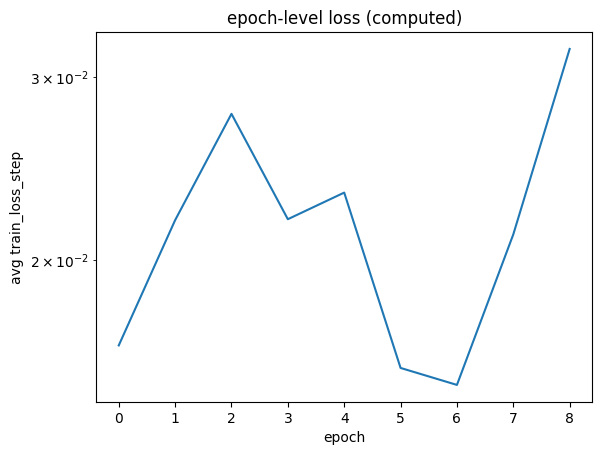

In [15]:
import glob, os, pandas as pd, matplotlib.pyplot as plt

# locate the latest metrics.csv
csv = max(glob.glob("/content/**/metrics.csv", recursive=True) +
          glob.glob("/content/drive/**/metrics.csv", recursive=True),
          key=os.path.getmtime)

df = pd.read_csv(csv)

if 'epoch' not in df.columns or 'train_loss_step' not in df.columns:
    print("File lacks epoch or train_loss_step columns.")
else:
    epoch_mean = df.groupby('epoch')['train_loss_step'].mean()
    print(epoch_mean.tail())          # show last few
    plt.plot(epoch_mean.values)
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel('avg train_loss_step')
    plt.title('epoch-level loss (computed)')
    plt.show()


In [16]:
# after your training run finishes
trainer.save_checkpoint("/content/drive/MyDrive/Embroidery Files/embronet_latest.ckpt")


NameError: name 'trainer' is not defined

In [9]:
## (A) List any checkpoints Lightning has already saved
import glob, pprint
ckpts = glob.glob("/content/**/checkpoints/*.ckpt", recursive=True)
ckpts += glob.glob("/content/drive/**/checkpoints/*.ckpt", recursive=True)
pprint.pp(ckpts)

# If the list prints something, copy one path:
# CKPT_PATH = "/content/lightning_logs/version_3/checkpoints/epoch=4-step=99.ckpt"

# (B) If the list is empty, save a quick checkpoint now (after training):
#trainer.save_checkpoint("/content/drive/MyDrive/EmbroideryTests/embronet.ckpt")
#CKPT_PATH = "/content/drive/MyDrive/EmbroideryTests/embronet.ckpt"


['/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=00-losstrain_loss=0.003.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=01-losstrain_loss=0.005.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=02-losstrain_loss=0.005.ckpt',
 '/content/drive/MyDrive/Embroidery Files/checkpoints/last.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=22-losstrain_loss=0.001.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=30-losstrain_loss=0.000.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=36-losstrain_loss=0.000.ckpt',
 '/content/drive/MyDrive/Embroidery Files/checkpoints/last-v1.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=04-losstrain_loss=0.022.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=05-losstrain_loss=0.022.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochep

In [7]:
import glob, pprint, os

# search inside the folder where you asked ModelCheckpoint to save
ckpts = glob.glob("/content/drive/MyDrive/Embroidery Files/checkpoints/*.ckpt")
pprint.pp(ckpts)


['/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=00-losstrain_loss=0.003.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=01-losstrain_loss=0.005.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=02-losstrain_loss=0.005.ckpt',
 '/content/drive/MyDrive/Embroidery Files/checkpoints/last.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=22-losstrain_loss=0.001.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=30-losstrain_loss=0.000.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=36-losstrain_loss=0.000.ckpt',
 '/content/drive/MyDrive/Embroidery Files/checkpoints/last-v1.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=04-losstrain_loss=0.022.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochepoch=05-losstrain_loss=0.022.ckpt',
 '/content/drive/MyDrive/Embroidery '
 'Files/checkpoints/epochep

In [23]:
CKPT_PATH = "/content/drive/MyDrive/Embroidery Files/checkpoints/last.ckpt"

In [24]:
import os
print("checkpoint exists?", os.path.exists(CKPT_PATH))

checkpoint exists? True


We are starting again. Here is it






In [25]:
# PyPI installs (run once per session)
from google.colab import drive
drive.mount('/content/drive')

!pip -q install pyembroidery pillow


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
##### Paths + Global Constants #######

# --------- EDIT THESE THREE PATHS ---------------------------------
PNG_PATH   = "/content/drive/MyDrive/Embroidery Files/pngstart/Copy of Cornerstone_Logo1.PNG"
CKPT_PATH  = "/content/drive/MyDrive/Embroidery Files/checkpoints/last-v2.ckpt"
OUT_PATH   = "/content/drive/MyDrive/Embroidery Files/outputs/test_logo15.dst"
# ------------------------------------------------------------------

SCALE_TRAIN = 4096.0   # the divisor you added in dataset.py
DESIGN_MM   = 100.0    # longest finished side (mm)
MAX_LEN     = 4096     # safety cap on generated stitches


In [60]:
##### Load Model + Run Inference ######
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from model import EmbroNet          # make sure model.py exists in /content

# 1) Load network
net = EmbroNet().eval()
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
state = {k.replace("net.", ""): v for k, v in state.items()}
net.load_state_dict(state, strict=False)
print("✓ checkpoint loaded")






# 2) Image → tensor
tfms = Compose([Resize((128,128)), ToTensor()])
img = tfms(Image.open(PNG_PATH).convert("RGB")).unsqueeze(0)

# 3) Autoregressive generate
seq = torch.zeros(1,1,3)
with torch.no_grad():
    for _ in range(MAX_LEN):
        seq = torch.cat([seq, net(img, seq)[:, -1:, :]], 1)

pred_seq = seq.squeeze(0)[1:]      # L×3  (Δx,Δy,flag)


✓ checkpoint loaded


In [61]:
# =================  CELL 4  ====================
import numpy as np, pathlib
from pyembroidery import EmbPattern, write

# --- 1. undo train-time shrink (pixels) ---------------------------
pred_pixels = pred_seq.clone()
pred_pixels[:, :2] *= SCALE_TRAIN            # back to pixel deltas

# --- 2. pixels → millimetres, fit DESIGN_MM ----------------------
xy_pix = pred_pixels[:, :2].cumsum(0)
span_pix = (xy_pix.max(0).values - xy_pix.min(0).values).max()
px_to_mm = DESIGN_MM / span_pix.item()

xy_mm_abs = xy_pix * px_to_mm                # absolute mm coords
xy_mm_abs -= xy_mm_abs.min(0).values         # shift to (0,0)

print("bbox in mm:", np.ptp(xy_mm_abs.numpy(), axis=0))  # expect ~[ 55.9 100 ]

# --- 3. build EmbPattern & save (mm → 0.1-mm inside pyembroidery) -
pat = EmbPattern()
deltas_mm = np.diff(                                # first row = (0,0)
    np.vstack([np.zeros((1,2)), xy_mm_abs.numpy()]),
    axis=0,
)
for dx_mm, dy_mm in deltas_mm:                     # relative mm moves ✅
    pat.stitch(float(dx_mm * 10), float(dy_mm * 10))
pat.end()

pathlib.Path(OUT_PATH).parent.mkdir(parents=True, exist_ok=True)
write(pat, OUT_PATH)
print("✓ saved", OUT_PATH)

# --- D. sanity print (correct) -----------------------------------
import numpy as np
from pyembroidery import read

pat = read(OUT_PATH)
coords = np.array([(x, y) for x, y, _ in pat.stitches])  # absolute, already 0.1-mm

span_units = np.ptp(coords, axis=0)          # max − min in 0.1-mm units
print("Design final size: {:.1f} × {:.1f} mm"
      .format(span_units[0] / 10, span_units[1] / 10))


bbox in mm: [99.99999   8.822985]
✓ saved /content/drive/MyDrive/Embroidery Files/outputs/test_logo15.dst
Design final size: 100.0 × 8.8 mm


TOOLS

In [63]:
####Stitch Count#####

from pyembroidery import read

pattern = read("/content/drive/MyDrive/Embroidery Files/outputs/test_logo15.dst")
print(f"Total stitches: {len(pattern.stitches)}")

Total stitches: 4105


In [57]:
#####Checking the checkpoints######
import os
from datetime import datetime

# Replace with your checkpoint path
ckpt_path = "/content/drive/MyDrive/Embroidery Files/checkpoints/last-v1.ckpt"

# Get the last modified time
timestamp = os.path.getmtime(ckpt_path)
print("🕒 Checkpoint last modified at:", datetime.fromtimestamp(timestamp))


🕒 Checkpoint last modified at: 2025-05-13 01:45:56


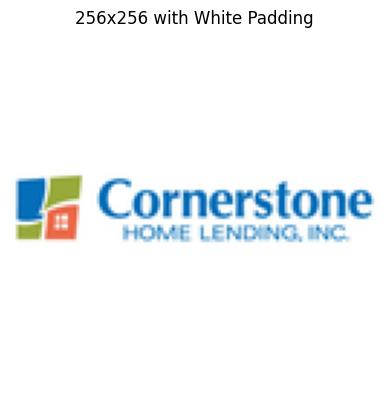

In [75]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def get_padding(img, target_size):
    w, h = img.size
    pad_w = target_size - w if w < target_size else 0
    pad_h = target_size - h if h < target_size else 0
    left = pad_w // 2
    right = pad_w - left
    top = pad_h // 2
    bottom = pad_h - top
    return (left, top, right, bottom)

img = Image.open("/content/drive/MyDrive/Embroidery Files/PNG_image_files/Cornerstone_Logo.PNG").convert("RGB")
img.thumbnail((128, 128), Image.LANCZOS)
padded = ImageOps.expand(img, get_padding(img, 128), fill=(255, 255, 255))

plt.imshow(padded)
plt.axis("off")
plt.title("256x256 with White Padding")
plt.show()


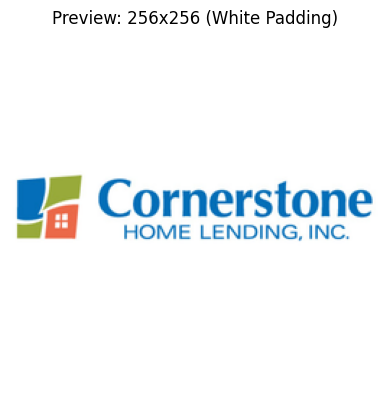

In [78]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Padding function — already in your codebase
def get_padding(img, target_size):
    w, h = img.size
    pad_w = target_size - w if w < target_size else 0
    pad_h = target_size - h if h < target_size else 0
    left   = pad_w // 2
    right  = pad_w - left
    top    = pad_h // 2
    bottom = pad_h - top
    return (left, top, right, bottom)

# Load and process image (your PNG)
img_path = "/content/drive/MyDrive/Embroidery Files/PNG_image_files/Cornerstone_Logo.PNG"
img = Image.open(img_path).convert("RGB")

# Resize shortest side to TARGET_SIZE while preserving aspect ratio
TARGET_SIZE = 256
img.thumbnail((TARGET_SIZE, TARGET_SIZE), Image.LANCZOS)

# Add white padding
padded = ImageOps.expand(img, get_padding(img, TARGET_SIZE), fill=(255, 255, 255))

# Optional: enforce final 256x256 size (sometimes rounding causes 255x256)
final = padded.resize((TARGET_SIZE, TARGET_SIZE), Image.LANCZOS)

# Show preview
plt.imshow(final)
plt.axis("off")
plt.title(f"Preview: {TARGET_SIZE}x{TARGET_SIZE} (White Padding)")
plt.show()
